In [57]:
import json
import re
import pandas as pd
import numpy as np
import dask.bag as db
from matplotlib import pyplot as plt
from pylab import rcParams
from matplotlib import rc

In [4]:
rcParams['figure.figsize'] = 10, 6
RANDOM_SEED = 9
np.random.seed(RANDOM_SEED)

### Look at what we get from the arxiv metadata

In [5]:
info = db.read_text("arxiv-metadata-oai-snapshot.json").map(json.loads)

In [6]:
info.count().compute()

1796911

In [7]:
info.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## Look at the number of submissions as a function of time

In [8]:
first_v = lambda x: x['versions'][0]['created']
first_v(info.take(1)[0])

'Mon, 2 Apr 2007 19:18:42 GMT'

In [9]:
dates_freq = info.map(first_v).frequencies(sort=True)

In [10]:
dates_freq.topk(10, key=1).compute()

[('Wed, 27 Jun 2012 19:59:59 GMT', 109),
 ('Tue, 14 Feb 2012 16:41:17 GMT', 83),
 ('Thu, 15 Mar 2012 11:17:56 GMT', 78),
 ('Sun, 1 Dec 2002 00:00:00 GMT', 33),
 ('Wed, 1 Apr 1992 00:00:00 GMT', 22),
 ('Wed, 8 Apr 1992 22:58:34 GMT', 18),
 ('Thu, 9 Feb 1995 00:00:00 GMT', 18),
 ('Thu, 1 Jul 1999 00:00:00 GMT', 17),
 ('Wed, 1 Jan 1992 00:00:00 GMT', 17),
 ('Fri, 9 Jul 1993 00:00:00 GMT', 17)]

In [11]:
dates_df = dates_freq.to_dataframe(columns = ['sub_datetime', 'sub']).compute()

In [12]:
date_format = '%a, %d %b %Y %H:%M:%S %Z'
dates_df['sub_datetime'] = pd.to_datetime(dates_df.sub_datetime, format = date_format)

In [13]:
dates_df['sub_date'] = dates_df.sub_datetime.dt.date

In [14]:
dates_df['sub_year'] = dates_df.sub_datetime.dt.year
dates_df.head()

,sub_datetime,sub,sub_date,sub_year
0,2012-06-27 19:59:59+00:00,109,2012-06-27,2012
1,2012-02-14 16:41:17+00:00,83,2012-02-14,2012
2,2012-03-15 11:17:56+00:00,78,2012-03-15,2012
3,2002-12-01 00:00:00+00:00,33,2002-12-01,2002
4,1992-04-01 00:00:00+00:00,22,1992-04-01,1992


In [15]:
dates2 = dates_df.groupby('sub_date').sum().reset_index()
dates3 = dates_df.groupby('sub_year').sum().reset_index()

In [16]:
dates2.head()

,sub_date,sub,sub_year
0,1986-04-25,1,1986
1,1988-11-11,1,1988
2,1989-04-15,1,1989
3,1989-10-26,3,1989
4,1989-11-09,1,1989


In [17]:
dates3.head()

,sub_year,sub
0,1986,1
1,1988,1
2,1989,6
3,1990,26
4,1991,353


In [18]:
%matplotlib inline

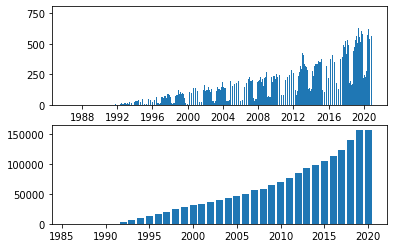

In [19]:
fig, ax = plt.subplots(2)
ax[0].bar(dates2['sub_date'], dates2['sub'])
ax[1].bar(dates3['sub_year'], dates3['sub'])
plt.show()

## Keep papers from two 3-year timespans separated 10 years apart: [2008, 2009, 2010, 2018, 2019, 2020]. (also keep my papers)

In [20]:
trim = lambda x: {'id': x['id'],
                  'category': x['categories'].split(' '),
                 'abstract': x['abstract']}

In [21]:
info_spans = info.filter(lambda x: int(first_v(x).split(' ')[3]) in [2008, 2009, 2010, 2018, 2019, 2020]).map(trim).compute()

In [22]:
info_me = info.filter(lambda x: ['Schillo', 'Marjorie', ''] in x['authors_parsed']).map(trim).compute()

In [23]:
subs = pd.DataFrame(info_spans)
subs_me = pd.DataFrame(info_me)

subs['year'] = subs.id.apply(lambda x: x[:2])
subs_me['year'] = subs_me.id.apply(lambda x: x[:2])

In [24]:
print(f'{subs.shape[0]} papers for 2008, 2009, 2010, 2018, 2019, 2020')
print(f'{subs_me.shape[0]} papers for me')

646426 papers for 2008, 2009, 2010, 2018, 2019, 2020
13 papers for me


#### only look at general category containing all sub-categories

In [25]:
subs['category'] = subs.category.apply(lambda x: [a.split('.')[0] for a in x])
subs_me['category'] = subs_me.category.apply(lambda x: [a.split('.')[0] for a in x])
subs['category'] = subs.category.apply(lambda x: list(dict.fromkeys(x)))
subs_me['category'] = subs_me.category.apply(lambda x: list(dict.fromkeys(x)))

## separate categories into submission category and cross-lists

In [26]:
subs['cross_lists']=subs.category.apply(lambda x: x[1:])
subs['category']=subs.category.apply(lambda x: x[0])

subs_me['cross_lists']=subs_me.category.apply(lambda x: x[1:])
subs_me['category']=subs_me.category.apply(lambda x: x[0])

In [27]:
print(f'{subs.shape[0]} papers for 6 years , {subs_me.shape[0]} papers for me')

646426 papers for 6 years , 13 papers for me


In [28]:
subs_me[:][['category', 'cross_lists', 'year']]

,category,cross_lists,year
0,astro-ph,"[gr-qc, hep-th]",12
1,hep-th,"[astro-ph, gr-qc]",12
2,hep-th,"[astro-ph, gr-qc]",12
3,astro-ph,[hep-th],13
4,hep-th,[astro-ph],14
5,hep-th,"[gr-qc, hep-ph]",15
6,hep-th,[gr-qc],15
7,hep-th,[],16
8,hep-th,[],17
9,hep-th,"[gr-qc, hep-ph]",18


## look at number of submissions per category per year

In [29]:
catcounts = subs.groupby(['year', 'category'])['id'].count()
catcounts.head(20)

year  category
08    astro-ph    10127
      cond-mat    10239
      cs           3256
      gr-qc        1867
      hep-ex        923
      hep-lat       515
      hep-ph       4169
      hep-th       3318
      math        12246
      math-ph      1256
      nlin          760
      nucl-ex       550
      nucl-th      1047
      physics      3870
      q-bio         713
      q-fin         285
      quant-ph     3070
      stat          456
09    astro-ph    11280
      cond-mat    10305
Name: id, dtype: int64

In [30]:
catcounts['08'].index[catcounts['08'].argmin()]

'q-fin'

#### Set a minimum number of submissions needed per year to keep a category

In [31]:
MIN_CAT = 400

In [32]:
allcategories = list(subs.category.unique())
keepcategories = allcategories.copy()

In [33]:
catcounts_cut=catcounts[catcounts > MIN_CAT]
catsperyear=[list(catcounts_cut[yr].index) for yr in list(catcounts_cut.index.unique(level=0))]

In [34]:
for i in range(len(catsperyear)):
    keepcategories = [x for x in keepcategories if x in catsperyear[i]]

removedcategories = [x for x in allcategories if x not in keepcategories]
print(f'categories kept: {keepcategories}')
print(f'categories removed: {removedcategories}')

categories kept: ['math', 'astro-ph', 'hep-ph', 'math-ph', 'hep-th', 'physics', 'quant-ph', 'cs', 'nucl-ex', 'cond-mat', 'stat', 'nlin', 'q-bio', 'nucl-th', 'hep-ex', 'gr-qc']
categories removed: ['hep-lat', 'q-fin', 'eess', 'econ']


### only keep those categories (I have no idea how year includes some few 11's, just kill them)

In [35]:
subscut = subs[subs.category.apply(lambda x: x in keepcategories)]
subscut = subscut[subscut.year.apply(lambda x: x in list(catcounts_cut.index.unique(level=0)))]
print(f'{subs.shape[0]} papers initially')
print(f'{subscut.shape[0]} papers after removing small categories')

646426 papers initially
621367 papers after removing small categories


In [237]:
arxiv_sample = subscut.groupby(['year', 'category']).sample(n=MIN_CAT, random_state=RANDOM_SEED)
original = subscut.groupby(['year', 'category']).sample(n=MIN_CAT, random_state=RANDOM_SEED)
print(MIN_CAT*len(keepcategories)*6)
print(arxiv_sample.shape)

38400
(38400, 5)


#### add a piece to remove newline characters

In [238]:
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: x.replace('\n', ' ') )

#### add a piece to rewrite LaTeX as EQUATION

In [239]:
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'\$(.+?)\$', 'equation', x, flags=re.UNICODE))

### add a piece to:
 #### replace all numbers with NUMBER
 #### replace all greek letters with LETTER 
 #### remove {,},|
 #### switch stupid LaTeX \`\` to \' 
 #### take super/sub scripts to space
 
 

In [240]:
greek = [r'\\alpah', r'\\beta', r'\\gamma', r'\\delta', r'\\epsilon', r'\\zeta', r'\\theta', r'\\eta', r'\\iota', r'\\kappa', r'\\lambda', r'\\mu', r'\\nu', r'\\xi', r'\\omicron', r'\\pi', r'\\rho', r'\\sigma', r'\\tau', r'\\upsilon', r'\\phi', r'\\chi', r'\\psi', r'\\omega']
Greek = [r'\\Alpah', r'\\Beta', r'\\Gamma', r'\\Delta', r'\\Epsilon', r'\\Zeta', r'\\Theta', r'\\Eta', r'\\Iota', r'\\Kappa', r'\\Lambda', r'\\Mu', r'\\Nu', r'\\Xi', r'\\Omicron', r'\\Pi', r'\\Rho', r'\\Sigma', r'\\Tau', r'\\Upsilon', r'\\Phi', r'\\Chi', r'\\Psi', r'\\Omega']
#arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'[0-9]+', 'NUMBER', x, flags=re.UNICODE))
for letter in greek + Greek:
    arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(letter, 'letter', x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'[\|\{\}]', '', x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'\`\`', r"'", x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'\'\'', r"'", x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'[\^\_\+]', '', x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'\\"o', 'o', x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'\\"a', 'a', x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'\\"u', 'u', x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'\\pm', '', x, flags=re.UNICODE))
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: re.sub(r'-->', 'to', x, flags=re.UNICODE))

In [241]:
arxiv_sample['abstract'] = arxiv_sample.abstract.apply(lambda x: x[2:-1])

In [282]:
TESTNUM = 13115
arxiv_sample.loc[arxiv_sample.index[TESTNUM]].abstract

'Atmospheric turbulence is an important limit to high angular resolution in astronomy. Interferometry resolved this issue by filtering the incoming light with single-mode fibers. Thanks to this technique, we obtained with the IOTA interferometer very precise measurements of the spatial frequencies of seven evolved stars. From these measurements, we performed a blind deconvolution to restore an image of the surface of the stars. Six of the them, Betelgeuse, Mu Cep, R leo, Mira, Chi Cyg and CH Cyg, feature very asymmetrical brightness distributions. On the other hand, the Arcturus data are extremely well fitted with a simple limb-darkened photospheric disc. From the observations of equation Cyg, we show that the star is surrounded by a molecular shell undergoing a ballistic motion. We propose to use the same technique of spatial filtering with single-mode fibers to correct for the effect of turbulence in the pupil of a telescope. Because the pupil is redundant, this technique does requir

In [283]:
original.loc[arxiv_sample.index[TESTNUM]].abstract

'  Atmospheric turbulence is an important limit to high angular resolution in\nastronomy. Interferometry resolved this issue by filtering the incoming light\nwith single-mode fibers. Thanks to this technique, we obtained with the IOTA\ninterferometer very precise measurements of the spatial frequencies of seven\nevolved stars. From these measurements, we performed a blind deconvolution to\nrestore an image of the surface of the stars. Six of the them, Betelgeuse, Mu\nCep, R leo, Mira, Chi Cyg and CH Cyg, feature very asymmetrical brightness\ndistributions. On the other hand, the Arcturus data are extremely well fitted\nwith a simple limb-darkened photospheric disc. From the observations of $\\chi$\nCyg, we show that the star is surrounded by a molecular shell undergoing a\nballistic motion. We propose to use the same technique of spatial filtering\nwith single-mode fibers to correct for the effect of turbulence in the pupil of\na telescope. Because the pupil is redundant, this techniqu

In [267]:
original.loc[arxiv_sample.index[TESTNUM]].id

'0810.5182'

### original.loc[original.index[TESTNUM]].abstract

In [243]:
arxiv_sample.to_csv('arxiv_sample.csv', index=False, header=True)
subs_me.to_csv('my_papers.csv', index=False, header=True)